<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/STDAA_Graduate_Project_Silica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process**

# **(Silica Concentrate)**

## **1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

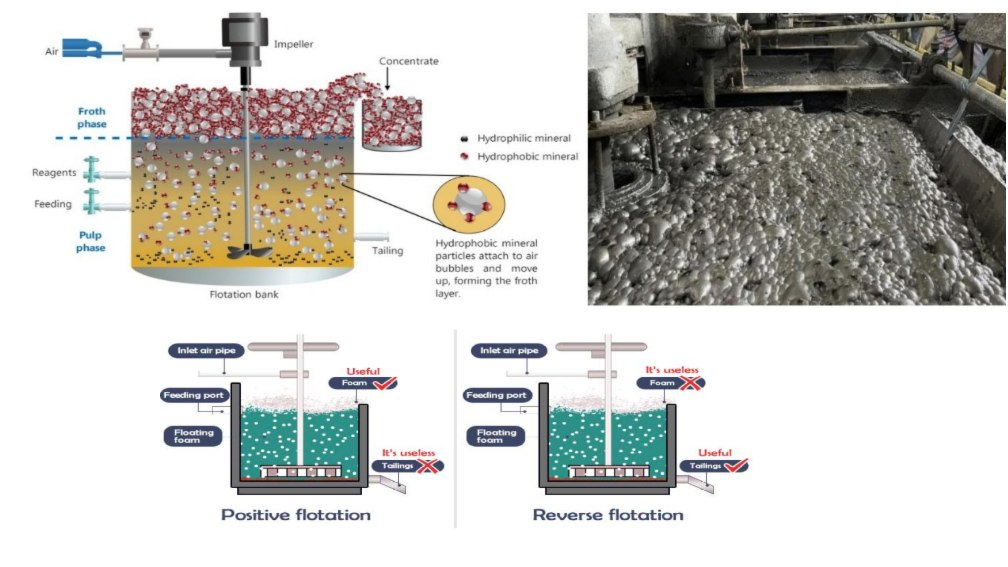

Flotation concentrate is periodically sampled to determine its purity (percentage of gangue). Higher purity in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict iron and gangue (silica) concentrate in the flotation output. The prediction will help process engineers assess the purity and take corrective actions in advance.

Source of dataset: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time. (There is imbalance in measurement of variables)
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

### **2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017).
- Measurements are taken every 5-6 hours for the first 2 columns (input - raw material).
- Measurements are taken every 1 hour for the last 2 columns (output - processed material).
- Some columns were sampled every 20 second.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant.
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process.
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality).
- The last two columns are the final iron ore pulp quality measurement from the lab.

### **2.3. Aim of the Project**

- To predict the percentage of output (iron and silica) concentrate in the mineral processing (reverse cationic flotation) plant

##**3. Data Collection**

###**3.1. Import Libraries**

In [85]:
import math
import random
import time
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
sns.set_theme(color_codes=True)
%matplotlib inline

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

###**3.2. Import Dataset**

In [86]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv',
                        parse_dates = True, index_col = 'date',decimal=',')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


**Memory using reduction**

In [87]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


##**4. Data Preprocessing**

###**4.1. Dataset Information**

In [88]:
flotation.sample(5).T

date,2017-03-30 00:00:00,2017-05-26 07:00:00,2017-07-26 04:00:00,2017-07-25 19:00:00,2017-04-25 00:00:00
% Iron Feed,59.540001,64.029999,57.459999,57.459999,48.770000
% Silica Feed,9.560000,6.260000,10.800000,10.800000,27.230000
Starch Flow,1947.280029,3620.429932,4697.830078,1031.981689,733.679993
Amina Flow,550.056030,532.489014,575.818970,689.565002,599.086975
Ore Pulp Flow,399.100006,406.278015,395.957001,398.902008,400.223999
Ore Pulp pH,9.640960,10.029600,10.398800,10.473900,9.572980
Ore Pulp Density,1.742800,1.752650,1.701970,1.714110,1.764550
Flotation Column 01 Air Flow,199.951004,299.696014,299.273987,300.743988,299.703003
Flotation Column 02 Air Flow,193.822006,300.187012,295.335999,305.065002,300.752014
Flotation Column 03 Air Flow,198.192993,300.829010,297.747009,299.171997,298.920013


In [89]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737453 entries, 2017-03-10 01:00:00 to 2017-09-09 23:00:00
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737453 non-null  float32
 1   % Silica Feed                 737453 non-null  float32
 2   Starch Flow                   737453 non-null  float32
 3   Amina Flow                    737453 non-null  float32
 4   Ore Pulp Flow                 737453 non-null  float32
 5   Ore Pulp pH                   737453 non-null  float32
 6   Ore Pulp Density              737453 non-null  float32
 7   Flotation Column 01 Air Flow  737453 non-null  float32
 8   Flotation Column 02 Air Flow  737453 non-null  float32
 9   Flotation Column 03 Air Flow  737453 non-null  float32
 10  Flotation Column 04 Air Flow  737453 non-null  float32
 11  Flotation Column 05 Air Flow  737453 non-null  float32
 12  Flotation 

In [90]:
flotation.describe().T

,count,mean,std,min,25%,50%,75%,max
% Iron Feed,737453.0,56.294743,5.157743,42.740002,52.669998,56.080002,59.720001,65.779999
% Silica Feed,737453.0,14.651719,6.807439,1.310000,8.940000,13.850000,19.600000,33.400002
Starch Flow,737453.0,2869.140381,1215.203735,0.002026,2076.320068,3018.429932,3727.729980,6300.229980
Amina Flow,737453.0,488.144653,91.230537,241.669006,431.795990,504.393005,553.257019,739.538025
Ore Pulp Flow,737453.0,397.578400,9.699785,376.248993,394.264008,399.248993,402.967987,418.640991
Ore Pulp pH,737453.0,9.767639,0.387007,8.753340,9.527360,9.798100,10.038000,10.808100
Ore Pulp Density,737453.0,1.680380,0.069249,1.519820,1.647310,1.697600,1.728330,1.853250
Flotation Column 01 Air Flow,737453.0,280.151886,29.621286,175.509995,250.281006,299.343994,300.148987,373.871002
Flotation Column 02 Air Flow,737453.0,277.159973,30.149357,175.156006,250.457001,296.222992,300.690002,375.992004
Flotation Column 03 Air Flow,737453.0,281.082489,28.558270,176.468994,250.854996,298.696014,300.381989,364.346008


###**4.2. Adjust and rename too long column names:**

In [91]:
flotation.columns

Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [92]:
# Rename column names
old_columns = ['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate']

new_columns = ["feed_Fe","feed_Si", "starch_flow", "amina_flow",
               "pulp_flow", "pulp_pH", "pulp_density",
               "air1", "air2", "air3", "air4", "air5", "air6", "air7",
               "level1", "level2", "level3", "level4", "level5", "level6", "level7",
               "conc_Fe", "conc_Si"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['feed_Fe', 'feed_Si', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'air1', 'air2', 'air3', 'air4', 'air5',
       'air6', 'air7', 'level1', 'level2', 'level3', 'level4', 'level5',
       'level6', 'level7', 'conc_Fe', 'conc_Si'],
      dtype='object')

The dataframe contains data about:

- Quality measures of the iron ore pulp before feeding it into the process (**inputs**)
- Features that can effect the quality of the product (**process parameters**)
- Quality measures of the iron ore pulp as product of the process (**outputs**)

### **4.3. Plot the variables graphs in time:**

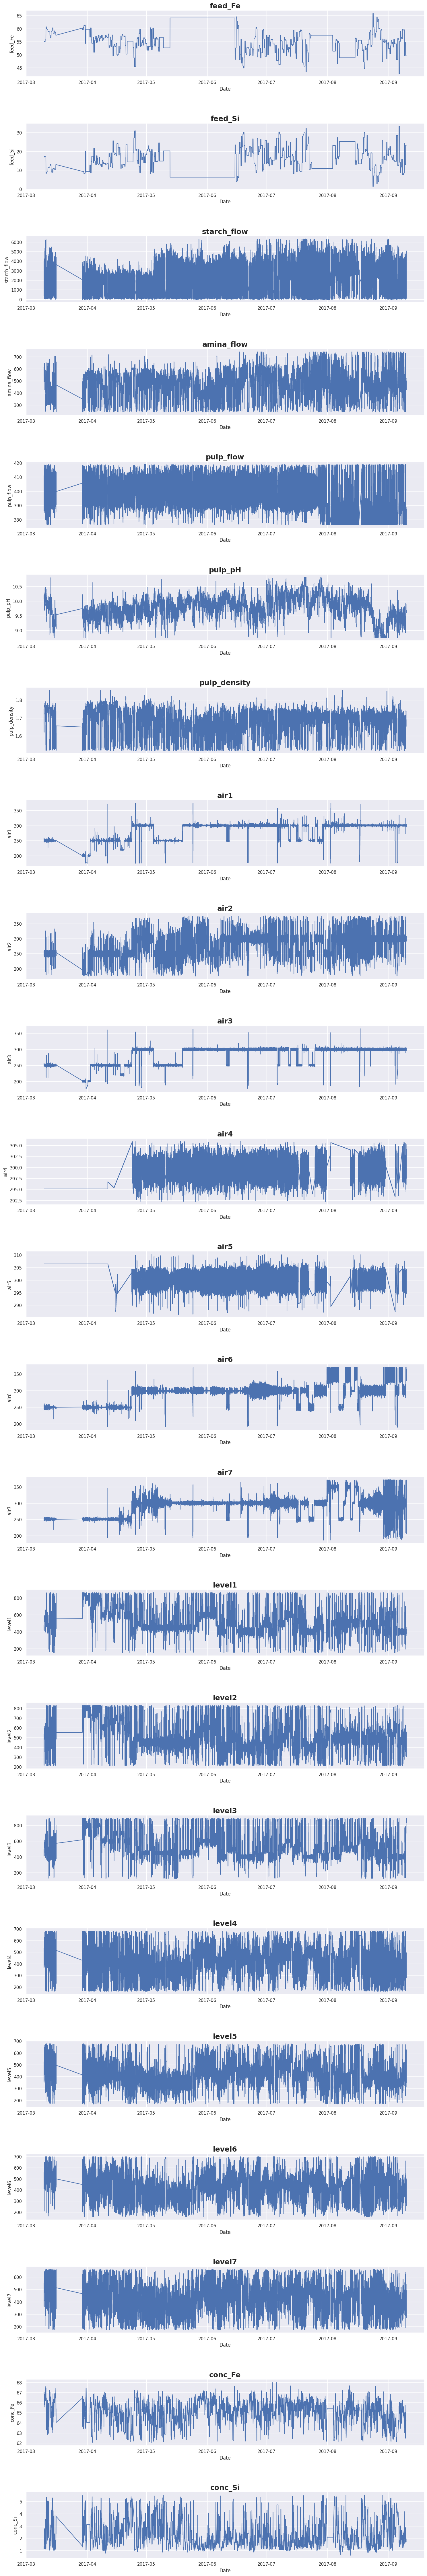

In [93]:
columns = flotation.columns

num_columns = 1
num_rows = (len(columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 90))
axes = axes.flatten()

# Loop over the columns and create plots
for i, column in enumerate(columns):
    axes[i].plot(flotation.index, flotation[column])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].set_title(column, fontsize=18, fontweight='bold')

if len(columns) < len(axes):
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

plt.tight_layout(h_pad=5)
plt.show()

The dataset misses data packages of a couple of days. This was probably caused by a production shutdown. In order to rule out any influences from potentially corrupted data, it will be trimmed the data earlier of the restart of production ("2017-03-29 12:00:00"). We can also see that the quality of the products does not seem to follow a clear temporal dependency.

In [94]:
sep_date = "2017-03-29 12:00:00"
ind_date = flotation.index<sep_date #boolean of earlier dates
flotation.drop(flotation.index[ind_date],inplace=True)
flotation.head().T

date,2017-03-29 12:00:00,2017-03-29 12:00:00,2017-03-29 12:00:00,2017-03-29 12:00:00,2017-03-29 12:00:00
feed_Fe,60.180000,60.180000,60.180000,60.180000,60.180000
feed_Si,9.340000,9.340000,9.340000,9.340000,9.340000
starch_flow,2044.989990,2020.550049,2012.839966,2007.670044,2003.920044
amina_flow,349.911011,353.063995,356.217010,359.371002,362.523987
pulp_flow,405.625000,404.402008,403.179993,401.957001,400.734985
pulp_pH,9.746040,9.741690,9.737330,9.732980,9.728620
pulp_density,1.649650,1.643469,1.637289,1.631108,1.624928
air1,200.393005,200.130997,199.869003,199.606995,199.345001
air2,195.733994,196.475998,197.218994,197.960999,198.703003
air3,201.826004,200.908997,199.992004,199.074997,198.158005


- That revealed a high (negative) correlations between the 'Iron Feed' and 'Silica Feed' (both Inputs of the process) as well as 'Iron Concentrate' and 'Silica Concentrate' (both Outputs of the process from the lab measurement).
- This situation basically says, higher the quality of the Iron, the less Silica it contains.

## **4.5. Averaging dataset to account for differently sampled features**

Based on the documentation of the dataset, some columns are sampled every 20 seconds, some every hour. For instance, the feature 'Ore Pulp Flow' changes continously during the process while the features '% Iron Feed' and '% Silica Feed' are sample only every hour. Thus, I think it is not really helpful to use every row (sampled every 20s) including the less sampled features (held constant over the duration of one hour), since this assumes that every row is an individual observation - which it isnt. Using all samples to train our model does not really represent the reality. What we can try to do is to mean the rows (observations) for every hour and create a new dataframe which uses the average of the 20s samples. This however, will strongly reduce our data size (by factor 180). What we can do to not lose all information of the 20s sampled features, is to also include their variations during one hour (e.g. by calculating also the standard deviation of the meaned columns).

In [95]:
flotation_mean = flotation.copy()

# Group the DataFrame by 'date' and calculate the mean
mean_grpby = flotation_mean.groupby('date').mean()
# Group the DataFrame by 'date' and calculate the standard deviation
std_grpby = flotation_mean.groupby('date').std()
# Remove columns with zero variance (null columns)
std_grpby = std_grpby.loc[:, (std_grpby != 0).any()]
# Add prefix 'std_' to the column names
std_grpby = std_grpby.add_prefix('std_')
# Merge the mean and standard deviation DataFrames on 'date'
flotation_merge = mean_grpby.merge(std_grpby, on='date')
# Assign the merged DataFrame back to 'flotation'
flotation = flotation_merge

In [96]:
# Calculate descriptive statistics for the DataFrame
flotation_stats = flotation.describe().T

**Check missing and duplicated values:**

In [97]:
missing_values = flotation.isnull().sum()
missing_values

feed_Fe             0
feed_Si             0
starch_flow         0
amina_flow          0
pulp_flow           0
pulp_pH             0
pulp_density        0
air1                0
air2                0
air3                0
air4                0
air5                0
air6                0
air7                0
level1              0
level2              0
level3              0
level4              0
level5              0
level6              0
level7              0
conc_Fe             0
conc_Si             0
std_starch_flow     0
std_amina_flow      0
std_pulp_flow       0
std_pulp_pH         0
std_pulp_density    0
std_air1            0
std_air2            0
std_air3            0
std_air4            0
std_air5            0
std_air6            0
std_air7            0
std_level1          0
std_level2          0
std_level3          0
std_level4          0
std_level5          0
std_level6          0
std_level7          0
std_conc_Fe         0
std_conc_Si         0
dtype: int64

In [98]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

feed_Fe             0
feed_Si             0
starch_flow         0
amina_flow          0
pulp_flow           0
pulp_pH             0
pulp_density        0
air1                0
air2                0
air3                0
air4                0
air5                0
air6                0
air7                0
level1              0
level2              0
level3              0
level4              0
level5              0
level6              0
level7              0
conc_Fe             0
conc_Si             0
std_starch_flow     0
std_amina_flow      0
std_pulp_flow       0
std_pulp_pH         0
std_pulp_density    0
std_air1            0
std_air2            0
std_air3            0
std_air4            0
std_air5            0
std_air6            0
std_air7            0
std_level1          0
std_level2          0
std_level3          0
std_level4          0
std_level5          0
std_level6          0
std_level7          0
std_conc_Fe         0
std_conc_Si         0
dtype: int64

In [99]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3948 entries, 2017-03-29 12:00:00 to 2017-09-09 23:00:00
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   feed_Fe           3948 non-null   float32
 1   feed_Si           3948 non-null   float32
 2   starch_flow       3948 non-null   float32
 3   amina_flow        3948 non-null   float32
 4   pulp_flow         3948 non-null   float32
 5   pulp_pH           3948 non-null   float32
 6   pulp_density      3948 non-null   float32
 7   air1              3948 non-null   float32
 8   air2              3948 non-null   float32
 9   air3              3948 non-null   float32
 10  air4              3948 non-null   float32
 11  air5              3948 non-null   float32
 12  air6              3948 non-null   float32
 13  air7              3948 non-null   float32
 14  level1            3948 non-null   float32
 15  level2            3948 non-null   float32
 16  level3

### **4.4. Pearson correlations between variables:**

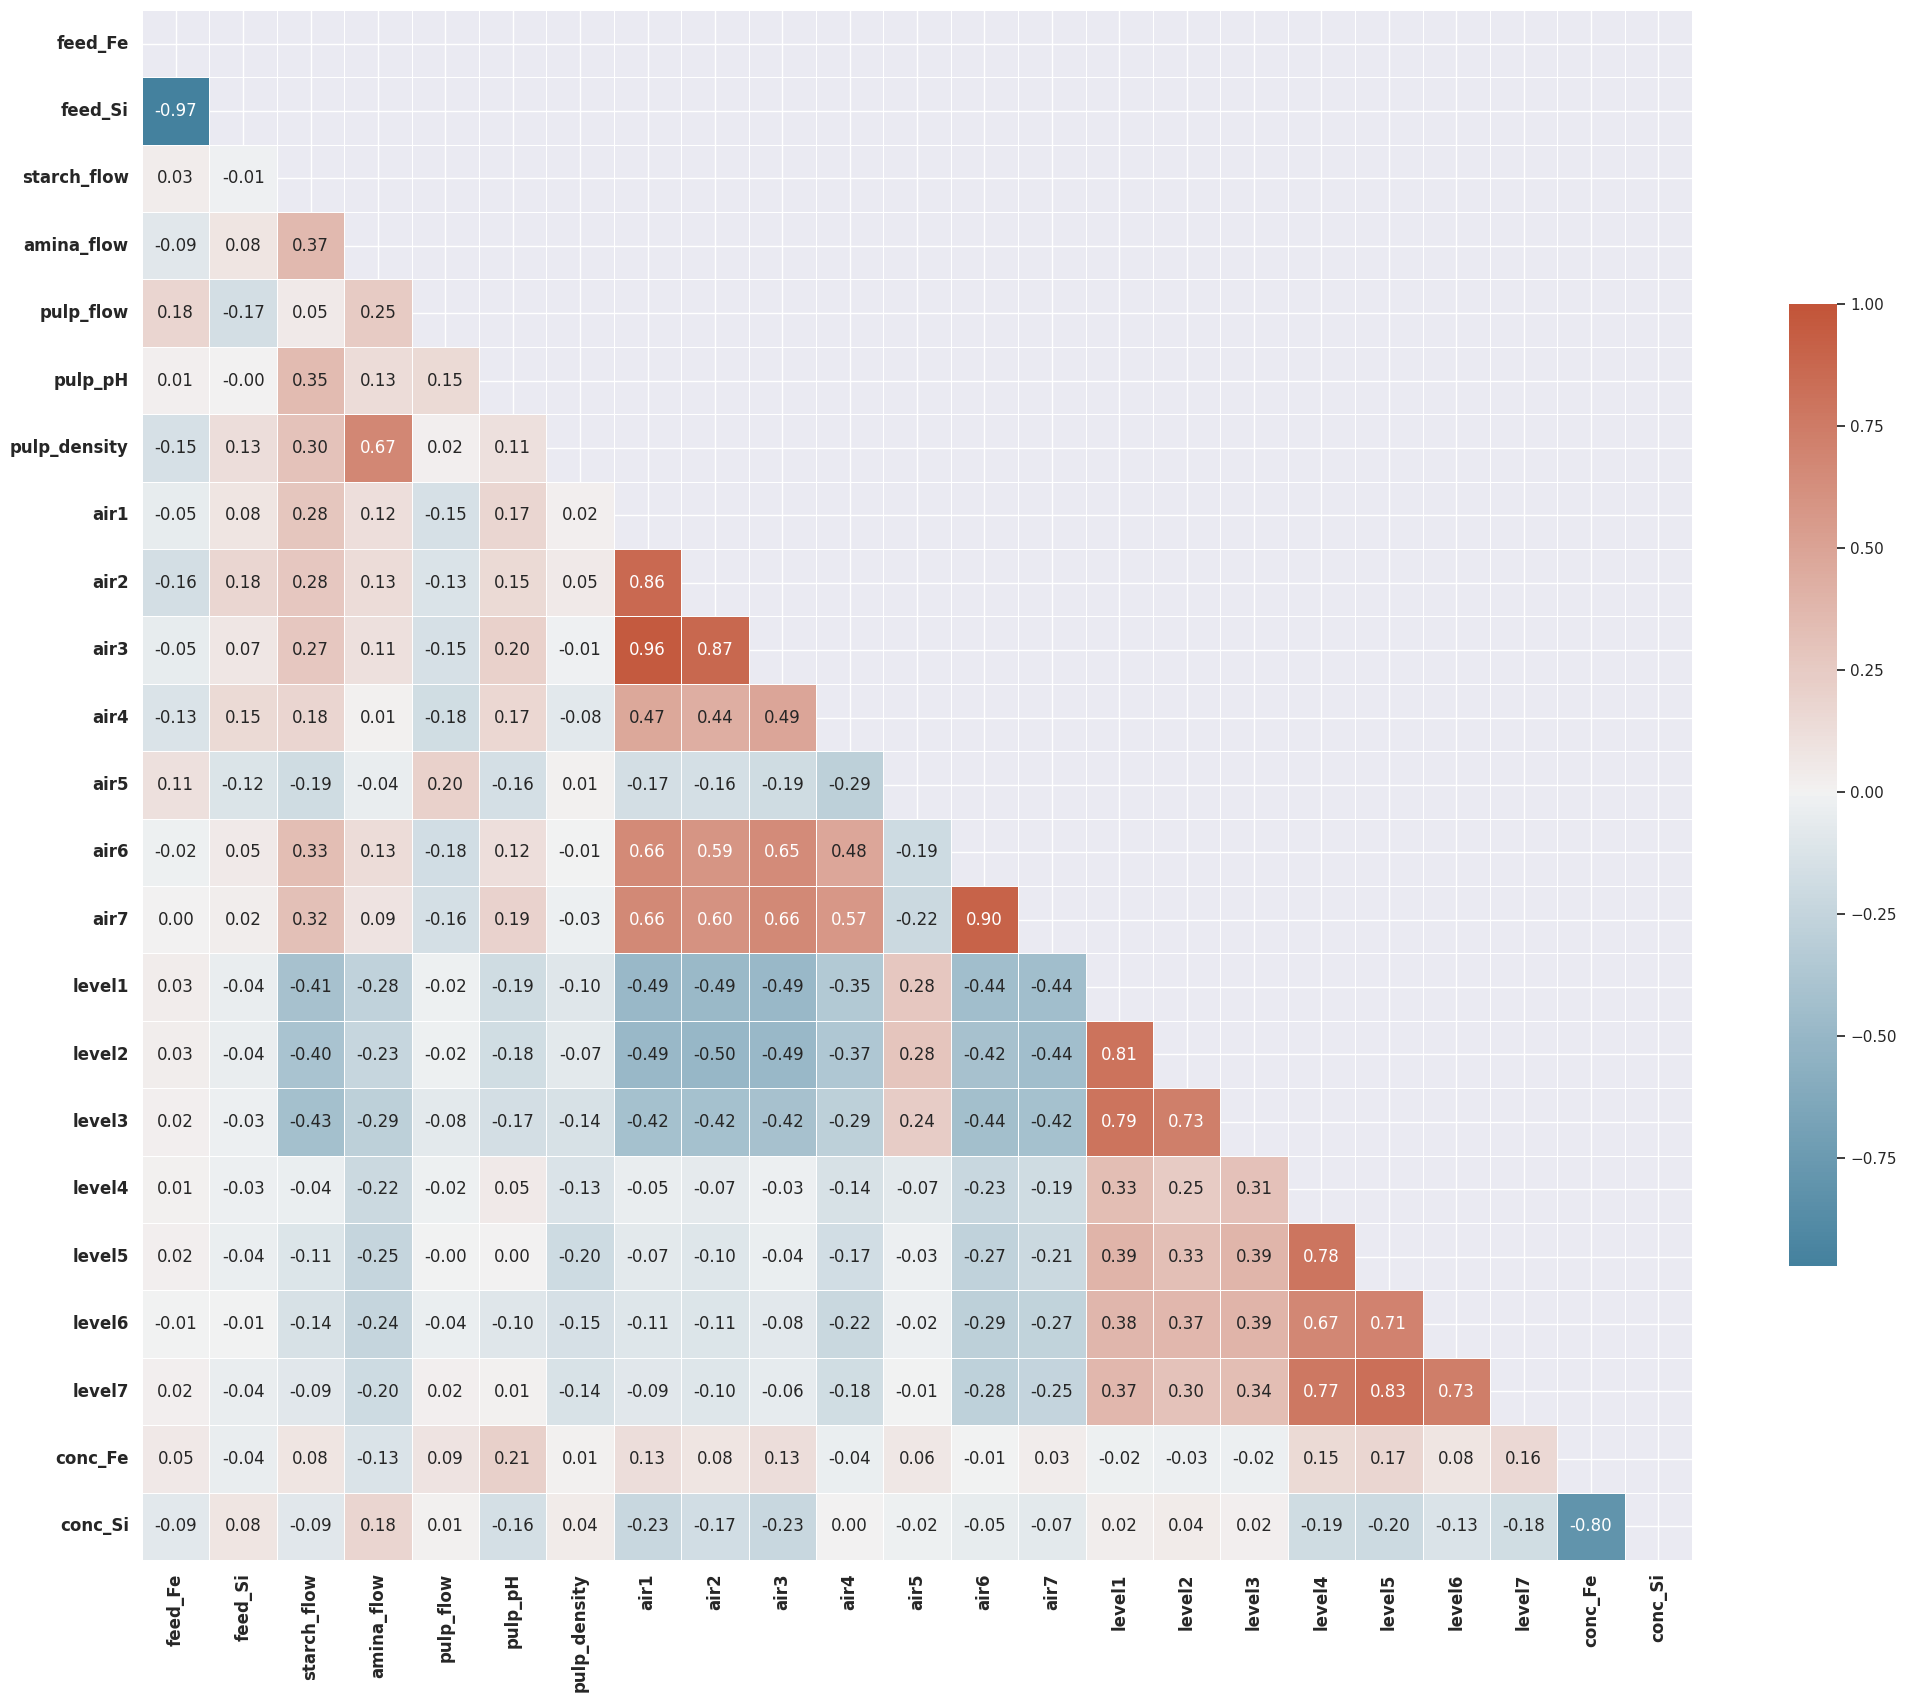

In [100]:
subset = flotation.loc[:, ~flotation.columns.str.startswith('std')]

# Calculate the correlation matrix
mat = subset.corr('pearson')

mask = np.triu(np.ones_like(mat, dtype=bool))
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1,
            center=0, annot=True, square=True,
            linewidths=.5, annot_kws={"fontsize": 12},
            cbar_kws={"shrink": .5}, fmt='.2f')

# Set x and y axis tick font properties
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()